# This is the in situ and SSS collocation code. 


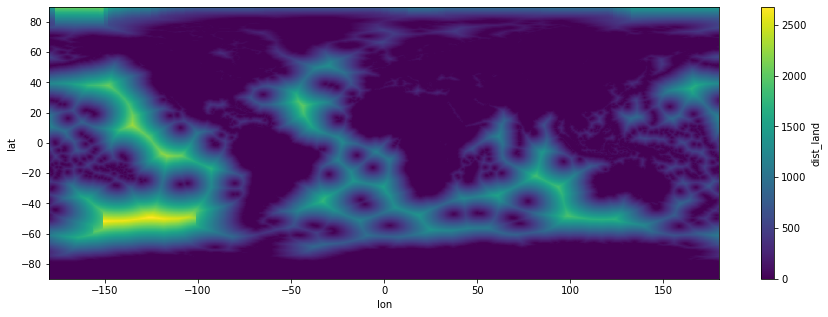

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import scipy
from glob import glob
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition
from pyresample.kd_tree import resample_nearest
import sys
sys.path.append('../saildrone/subroutines/')
from read_routines import read_one_usv, add_coll_vars,get_filelist_l2p,get_orbital_data_l2p
import warnings
warnings.simplefilter('ignore') # filter some warning messages


ds = xr.open_dataset('f:/data/sat_data/distance_to_land_25km.nc').rename({'i2':'lon','j2':'lat'})
ds['lat'],ds['lon']=np.arange(-89.875,89.876,.25),np.arange(-179.875,179.876,.25)#np.arange(.125,359.876,.25)
#ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
#ds = ds.sortby(ds.lon)
ds_land=ds
plt.rcParams['figure.figsize'] = (15,5)
ds_land.dist_land.plot()

# Read in USV data
Read in the Saildrone USV file either from a local disc or using OpenDAP.



In [2]:
dir_data = 'C:/Users/gentemann/Google Drive/public/ALL_saildrone_data/' #'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_pattern = 'C:/Users/gentemann/Google Drive/public/ALL_saildrone_data/*west*.nc' 

#get list of all filenames in directory
files = glob(dir_data_pattern)
print('number of file:',len(files))
for ifile,file in enumerate(files):
    print(ifile,file)

number of file: 13
0 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2018_sd1024.nc
1 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2018_sd1025.nc
2 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2018_sd1026.nc
3 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2018_sd1027.nc
4 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2018_sd1028.nc
5 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2019_sd1038.nc
6 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2019_sd1039.nc
7 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2019_sd1040.nc
8 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2019_sd1043.nc
9 C:/Users/gentemann/Google Drive/public/ALL_saildrone

In [3]:
#filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
#filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
iname=0
ds_usv=[]
for file in files:
    ds = read_one_usv(file)
    ds_usv.append(ds[0])
ds_usv=xr.concat(ds_usv,dim='trajectory')
#ds_usv = xr.open_mfdataset(files,concat_dim='trajectory')
#ds_usv.close()
#ds_usv = ds_usv.isel(trajectory=0).swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
#ds_usv = ds_usv.sel(time=slice('2018-04-12T02','2018-06-10T18')) #get rid of last part and first part where USV being towed
#ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear') #there are 6 nan values
#ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear')
#ds_usv['wind_speed']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)
#ds_usv['wind_dir']=np.arctan2(ds_usv.VWND_MEAN,ds_usv.UWND_MEAN)*180/np.pi
#ds_usv

In [4]:
ds

(<xarray.Dataset>
 Dimensions:                       (time: 108820)
 Coordinates:
     trajectory                    float32 ...
   * time                          (time) datetime64[ns] 2019-06-20T02:00:00 ....
 Data variables:
     lat                           (time) float64 ...
     lon                           (time) float64 ...
     SOG_MEAN                      (time) float64 ...
     COG_MEAN                      (time) float64 ...
     HDG_MEAN                      (time) float64 ...
     ROLL_MEAN                     (time) float64 ...
     PITCH_MEAN                    (time) float64 ...
     UWND_MEAN                     (time) float64 ...
     VWND_MEAN                     (time) float64 ...
     WWND_MEAN                     (time) float64 ...
     GUST_WND_MEAN                 (time) float64 ...
     WIND_MEASUREMENT_HEIGHT_MEAN  (time) float64 ...
     TEMP_AIR_MEAN                 (time) float64 ...
     RH_MEAN                       (time) float64 ...
     BARO_PRES_M

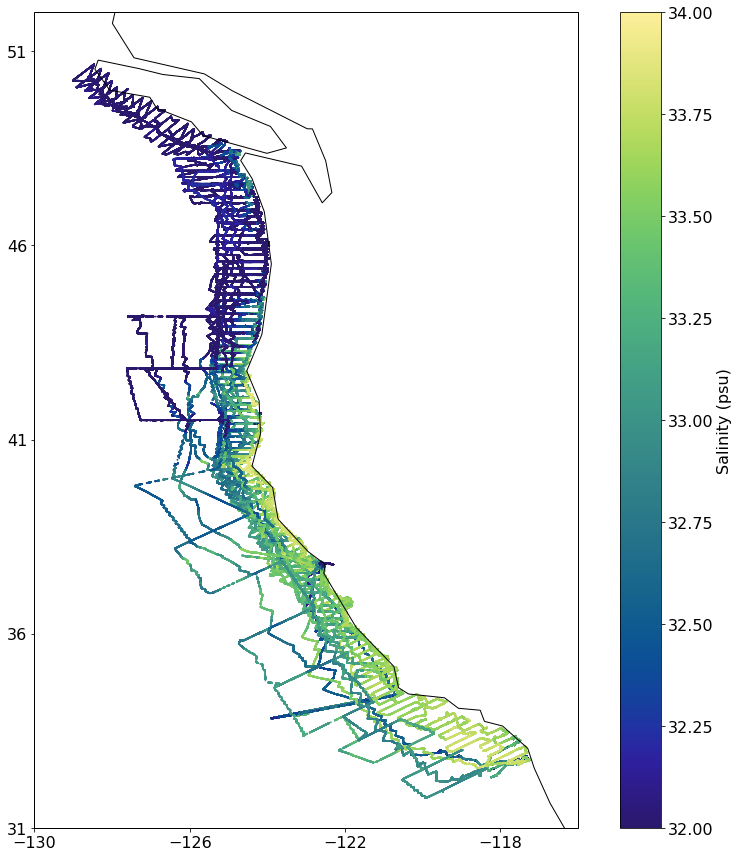

In [5]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.rcParams.update({'font.size': 16})
import cmocean
for i in range(len(ds_usv.trajectory)):
    ds=ds_usv.isel(trajectory=i)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.SAL_CTD_MEAN, edgecolor='none', cmap=cmocean.cm.haline,vmin=32,vmax=34)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_all_cruises.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [6]:
np.datetime64('2019-06-19')

numpy.datetime64('2019-06-19')

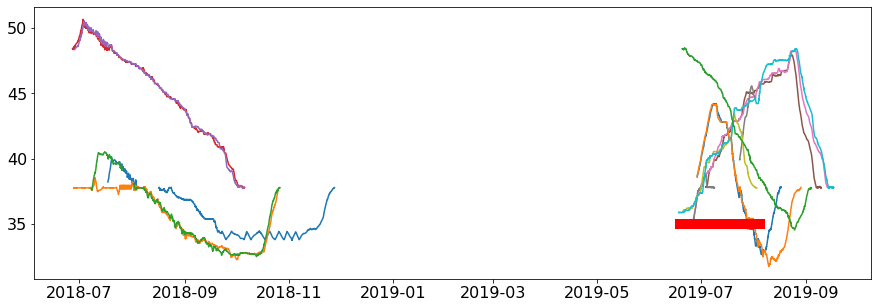

In [7]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 16})
import cmocean
for i in range(len(ds_usv.trajectory)):
    ds=ds_usv.isel(trajectory=i)
    #ax = plt.axes(projection=ccrs.PlateCarree())
    plt.plot(ds.time,ds.lat)
    plt.plot([np.datetime64('2019-06-19'),np.datetime64('2019-08-05')],[35,35],'r',linewidth=10) #DATA OUTAGE
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_all_cruises_timeseries.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [8]:
dir_data = 'F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat/' #'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_patternJ = 'F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat/*west*JPL*.nc' 
dir_data_patternR = 'F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat/*west*RSS*.nc' 

#get list of all filenames in directory
cfilesJ = glob(dir_data_patternJ)
cfilesR = glob(dir_data_patternR)
print('number of file:',len(cfilesR))
for ifile,file in enumerate(cfilesJ):
    print(ifile,file)

number of file: 13
0 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1024jplv04.3_orbitalnorep.nc
1 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1025jplv04.3_orbitalnorep.nc
2 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1026jplv04.3_orbitalnorep.nc
3 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1027jplv04.3_orbitalnorep.nc
4 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1028jplv04.3_orbitalnorep.nc
5 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2019_sd1038jplv04.3_orbitalnorep.nc
6 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2019_sd1039jplv04.3_orbitalnorep.nc
7 F:/data/cruise_data/saildrone/sss/sss_col

In [9]:
ds2=[]
for i in range(len(cfilesJ)):
    ds = xr.open_dataset(cfilesJ[i])
    ds2.append(ds)
ds_colJ = xr.concat(ds2,dim='trajectory')
ds2=[]
for i in range(len(cfilesR)):
    ds = xr.open_dataset(cfilesR[i])
    ds2.append(ds)
ds_colR = xr.concat(ds2,dim='trajectory')

ds=ds_land.interp(lat=ds_colJ.lat,lon=ds_colJ.lon).drop({'lat','lon'})
ds_colJ['dist_land']=ds.dist_land
ds=ds_land.interp(lat=ds_colR.lat,lon=ds_colR.lon).drop({'lat','lon'})
ds_colR['dist_land']=ds.dist_land

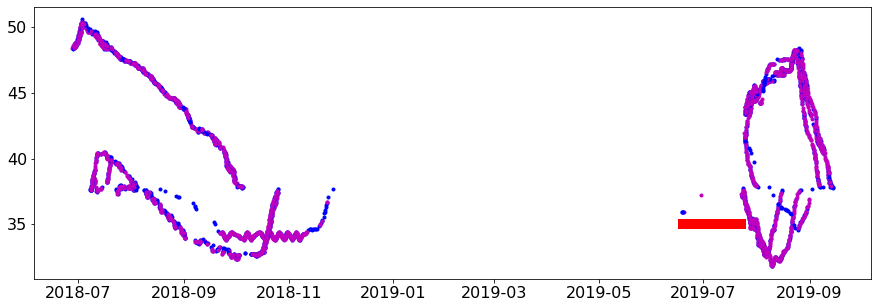

In [10]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 16})
import cmocean
for i in range(len(ds_usv.trajectory)):
    ds=ds_colJ.isel(trajectory=i)
    plt.plot(ds.time,ds.lat,'.',color='b',linewidth=3)
    ds=ds_colR.isel(trajectory=i)
    plt.plot(ds.time,ds.lat,'.',color='m')
    plt.plot([np.datetime64('2019-06-19'),np.datetime64('2019-07-23')],[35,35],'r',linewidth=10) #DATA OUTAGE
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_coll_cruises_timeseriesJPL.png'
plt.savefig(fig_fname, transparent=False, format='png')

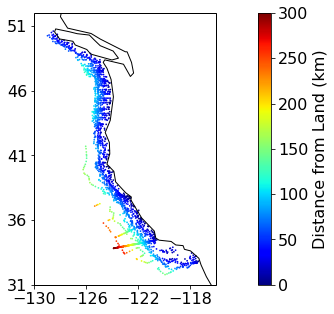

In [11]:
for i in range(13):
    ds=ds_colJ.isel(trajectory=i)
#    ds = ds.where(ds.dist_land>30)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.dist_land, edgecolor='none', cmap='jet',vmin=0,vmax=300)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Distance from Land (km)',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_distanceJPL.png'
plt.savefig(fig_fname, transparent=False, format='png')

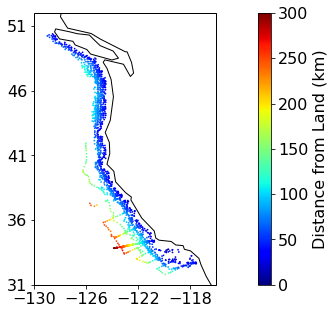

In [12]:
for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.dist_land, edgecolor='none', cmap='jet',vmin=0,vmax=300)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Distance from Land (km)',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_distanceRSS.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [13]:
ds_colJ

<xarray.Dataset>
Dimensions:                       (ob: 324, trajectory: 13)
Coordinates:
  * ob                            (ob) int64 0 1 2 3 4 5 ... 319 320 321 322 323
Dimensions without coordinates: trajectory
Data variables:
    lat                           (trajectory, ob) float64 38.23 38.24 ... nan
    lon                           (trajectory, ob) float64 -123.9 -124.0 ... nan
    SOG_MEAN                      (trajectory, ob) float64 1.539 1.505 ... nan
    COG_MEAN                      (trajectory, ob) float64 279.1 283.6 ... nan
    HDG_MEAN                      (trajectory, ob) float64 287.2 291.7 ... nan
    PITCH_MEAN                    (trajectory, ob) float64 2.697 2.714 ... nan
    BARO_PRES_MEAN                (trajectory, ob) float64 1.018e+03 ... nan
    TEMP_AIR_MEAN                 (trajectory, ob) float64 13.86 13.94 ... nan
    RH_MEAN                       (trajectory, ob) float64 94.17 93.44 ... nan
    PAR_AIR_MEAN                  (trajectory, ob) float64 624.0 683.3 ... nan
    UWND_MEAN                     (trajectory, ob) float64 3.849 3.34 ... nan
    VWND_MEAN                     (trajectory, ob) float64 -7.698 -7.929 ... nan
    WWND_MEAN                     (trajectory, ob) float64 0.07351 ... nan
    GUST_WND_MEAN                 (trajectory, ob) float64 9.725 9.869 ... nan
    TEMP_CTD_MEAN                 (trajectory, ob) float64 15.15 15.08 ... nan
    TEMP_CTD_STDDEV               (trajectory, ob) float64 0.004694 ... nan
    SAL_CTD_MEAN                  (trajectory, ob) float64 33.07 33.07 ... nan
    CHLOR_MEAN                    (trajectory, ob) float64 0.554 0.528 ... nan
    ROLL_MEAN                     (trajectory, ob) float64 1e+05 1e+05 ... nan
    TEMP_RBR_MEAN                 (trajectory, ob) float64 1e+05 1e+05 ... nan
    SAL_RBR_MEAN                  (trajectory, ob) float64 1e+05 1e+05 ... nan
    TEMP_O2_RBR_MEAN              (trajectory, ob) float64 1e+05 1e+05 ... nan
    CDOM_MEAN                     (trajectory, ob) float64 1e+05 1e+05 ... nan
    CHLOR_WETLABS_MEAN            (trajectory, ob) float64 1e+05 1e+05 ... nan
    WIND_MEASUREMENT_HEIGHT_MEAN  (trajectory, ob) float64 1e+05 1e+05 ... nan
    deltaT                        (trajectory, ob) float64 255.1 277.1 ... nan
    smap_SSS                      (trajectory, ob) float32 32.63 33.64 ... nan
    smap_fland                    (trajectory, ob) float32 -1.125e-13 ... nan
    smap_fice                     (trajectory, ob) float32 0.0 0.0 ... nan nan
    smap_iqc_flag                 (trajectory, ob) float64 2.0 2.0 ... nan nan
    smap_dist                     (trajectory, ob) float64 0.1849 0.1992 ... nan
    smap_ydim                     (trajectory, ob) float32 18.0 19.0 ... nan nan
    smap_xdim                     (trajectory, ob) float32 1.04e+03 ... nan
    smap_rev_number               (trajectory, ob) float64 1.847e+04 ... nan
    time                          (trajectory, ob) datetime64[ns] 2018-07-17T...
    dist_land                     (trajectory, ob) float64 65.26 66.82 ... nan
Attributes:
    area:                      unassigned
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    creator_url:               http://saildrone.com/
    data_mode:                 realtime
    date_created:              2018-10-06T00:30:01.915026Z
    description:               Saildrone NetCDF Format
    drone_id:                  1028
    Easternmost_Easting:       -120.5020928
    featureType:               Trajectory
    geospatial_lat_max:        40.0555744
    geospatial_lat_min:        33.8146944
    geospatial_lat_units:      degrees_north
    geospatial_lon_max:        -120.5020928
    geospatial_lon_min:        -124.915008
    geospatial_lon_units:      degrees_east
    history:                   FERRET V7.504  21-Jul-19

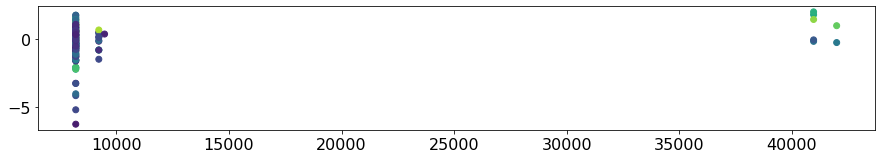

In [14]:
ds = ds_colR.isel(trajectory=6)
ds = ds.where((ds.dist_land>25) & (ds.SAL_CTD_MEAN>26))
dif = ds.SAL_CTD_MEAN,ds.SAL_CTD_MEAN-ds.smap_SSS
plt.subplot(2,1,1)
plt.scatter(ds.smap_iqc_flag,ds.SAL_CTD_MEAN-ds.smap_SSS,c=ds.dist_land)
#plt.scatter(ds.dist_land,ds.SAL_CTD_MEAN-ds.smap_SSS,c=ds.dist_land)


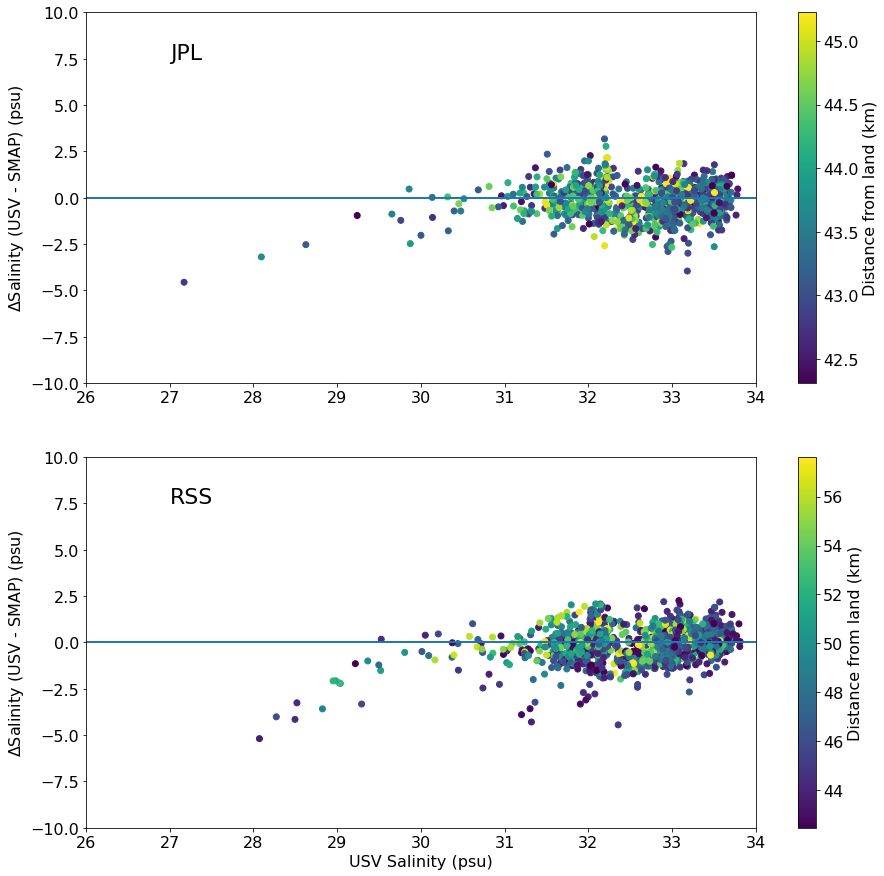

In [15]:
plt.rcParams['figure.figsize'] = (15.0,15.0)
plt.rcParams.update({'font.size': 16})
for i in range(13):
    ds = ds_colJ.isel(trajectory=i)
    ds = ds.where((ds.dist_land>25) & (ds.SAL_CTD_MEAN>26) & (ds.smap_iqc_flag<1))
    dif = ds.SAL_CTD_MEAN,ds.SAL_CTD_MEAN-ds.smap_SSS
    plt.subplot(2,1,1)
    plt.scatter(ds.SAL_CTD_MEAN,ds.SAL_CTD_MEAN-ds.smap_SSS,c=ds.dist_land)
    plt.axhline(0)
plt.text(27,7.5,'JPL',fontsize=22)
plt.xlim(26,34),plt.ylim(-10,10),plt.ylabel('$\Delta$Salinity (USV - SMAP) (psu)')
cb=plt.colorbar(label='Distance from land (km)')
for i in range(13):
    ds = ds_colR.isel(trajectory=i)
    #ds = ds.where((ds.smap_iqc_flag<1))
    ds = ds.where((ds.dist_land>40) & (ds.smap_iqc_flag<10000))
    dif = ds.SAL_CTD_MEAN,ds.SAL_CTD_MEAN-ds.smap_SSS
    plt.subplot(2,1,2)
    plt.axhline(0)
    plt.scatter(ds.SAL_CTD_MEAN,ds.SAL_CTD_MEAN-ds.smap_SSS,c=ds.dist_land)
plt.text(27,7.5,'RSS',fontsize=22)
plt.xlim(26,34),plt.ylim(-10,10),plt.ylabel('$\Delta$Salinity (USV - SMAP) (psu)'),plt.xlabel('USV Salinity (psu)')
cb=plt.colorbar(label='Distance from land (km)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_sal_scatter.png'
plt.savefig(fig_fname, transparent=False, format='png')

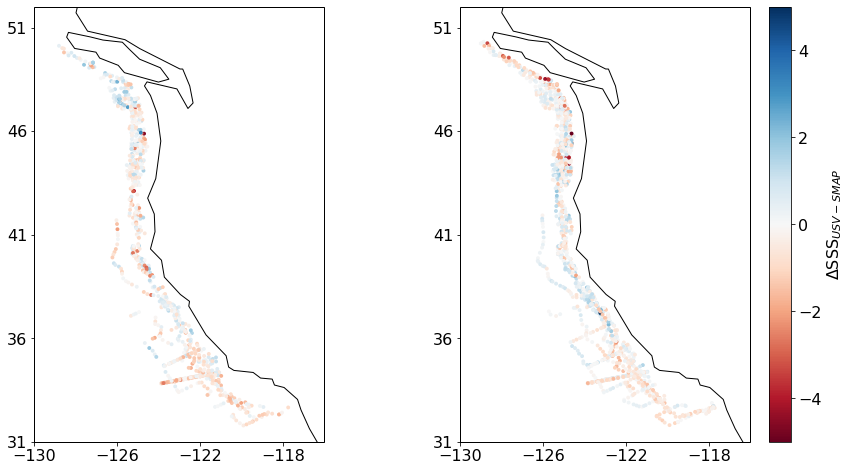

In [16]:
plt.rcParams['figure.figsize'] = (15.0,8.0)
plt.rcParams.update({'font.size': 16})

for i in range(13):
    ds=ds_colJ.isel(trajectory=i)
    ds = ds.where((ds.SAL_CTD_MEAN>26) & (ds.smap_iqc_flag<1))
#    ds = ds.where((ds.dist_land>25) & (ds.SAL_CTD_MEAN>26) & (ds.smap_iqc_flag<1))
    ax = plt.subplot(121,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=15.0, c=ds.SAL_CTD_MEAN-ds.smap_SSS, edgecolor='none', cmap='RdBu',vmin=-5,vmax=5)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))

for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    ds = ds.where((ds.dist_land>40) & (ds.smap_iqc_flag<10000))
    ax = plt.subplot(122,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=15.0, c=ds.SAL_CTD_MEAN-ds.smap_SSS, edgecolor='none', cmap='RdBu',vmin=-5,vmax=5)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))

cax = plt.colorbar(cs1)
cax.set_label('$\Delta$SSS$_{USV-SMAP}$',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_sal_dif.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [17]:
ds=ds_colJ.where((ds_colJ.dist_land>26) & (ds_colJ.SAL_CTD_MEAN>26) & (ds_colJ.smap_iqc_flag<1))
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print(ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)
ds=ds_colR.where((ds_colR.dist_land>40) & (ds_colR.smap_iqc_flag<10000))
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print(ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)

-0.20302986017057398 0.8782074041781945 993.0
-0.10541739561174754 1.2121996768867047 1396.0


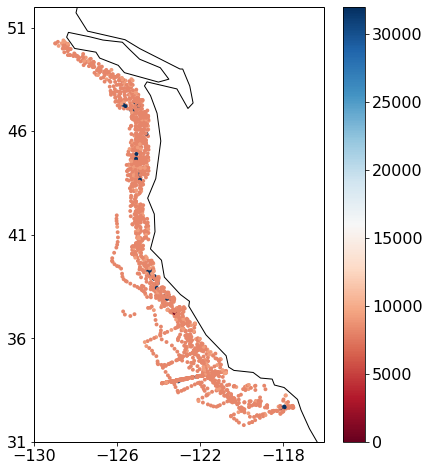

In [18]:
plt.rcParams['figure.figsize'] = (15.0,8.0)
plt.rcParams.update({'font.size': 16})

for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    #ds = ds.where((ds.SAL_CTD_MEAN>26) & (ds.smap_iqc_flag<1))
#    ds = ds.where((ds.dist_land>25) & (ds.SAL_CTD_MEAN>26) & (ds.smap_iqc_flag<1))
    ax = plt.subplot(121,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=15.0, c=ds.smap_iqc_flag, edgecolor='none', cmap='RdBu',vmin=0,vmax=32000)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)



In [19]:
ds1 = xr.open_dataset('F:/data/sat_data/smap/SSS/L2/JPL/V4.3/2019/001/SMAP_L2B_SSS_20921_20190101T005415_R16022_V4.3.h5')
ds2 = xr.open_dataset('F:/data/sat_data/smap/SSS/L2/RSS/V4/SCI/2019/001/RSS_SMAP_SSS_L2C_r20921_20190101T005327_2019001_FNL_V04.0.nc')

In [20]:
ds1

<xarray.Dataset>
Dimensions:               (phony_dim_0: 76, phony_dim_1: 1624, phony_dim_2: 4)
Coordinates:
    lat                   (phony_dim_0, phony_dim_1) float32 ...
    lon                   (phony_dim_0, phony_dim_1) float32 ...
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables:
    anc_dir               (phony_dim_0, phony_dim_1) float32 ...
    anc_spd               (phony_dim_0, phony_dim_1) float32 ...
    anc_sss               (phony_dim_0, phony_dim_1) float32 ...
    anc_sst               (phony_dim_0, phony_dim_1) float32 ...
    anc_swh               (phony_dim_0, phony_dim_1) float32 ...
    antazi_aft            (phony_dim_0, phony_dim_1) float32 ...
    antazi_fore           (phony_dim_0, phony_dim_1) float32 ...
    azi_aft               (phony_dim_0, phony_dim_1) float32 ...
    azi_fore              (phony_dim_0, phony_dim_1) float32 ...
    ice_concentration     (phony_dim_0, phony_dim_1) float32 ...
    inc_aft               (phony_dim_0, phony_dim_1) float32 ...
    inc_fore              (phony_dim_0, phony_dim_1) float32 ...
    land_fraction_aft     (phony_dim_0, phony_dim_1) float32 ...
    land_fraction_fore    (phony_dim_0, phony_dim_1) float32 ...
    n_h_aft               (phony_dim_0, phony_dim_1) float32 ...
    n_h_fore              (phony_dim_0, phony_dim_1) float32 ...
    n_v_aft               (phony_dim_0, phony_dim_1) float32 ...
    n_v_fore              (phony_dim_0, phony_dim_1) float32 ...
    nedt_h_aft            (phony_dim_0, phony_dim_1) float32 ...
    nedt_h_fore           (phony_dim_0, phony_dim_1) float32 ...
    nedt_v_aft            (phony_dim_0, phony_dim_1) float32 ...
    nedt_v_fore           (phony_dim_0, phony_dim_1) float32 ...
    num_ambiguities       (phony_dim_0, phony_dim_1) float32 ...
    quality_flag          (phony_dim_0, phony_dim_1) float32 ...
    row_time              (phony_dim_1) datetime64[ns] ...
    smap_ambiguity_dir    (phony_dim_0, phony_dim_1, phony_dim_2) float32 ...
    smap_ambiguity_spd    (phony_dim_0, phony_dim_1, phony_dim_2) float32 ...
    smap_high_dir         (phony_dim_0, phony_dim_1) float32 ...
    smap_high_dir_smooth  (phony_dim_0, phony_dim_1) float32 ...
    smap_high_spd         (phony_dim_0, phony_dim_1) float32 ...
    smap_spd              (phony_dim_0, phony_dim_1) float32 ...
    smap_sss              (phony_dim_0, phony_dim_1) float32 ...
    smap_sss_uncertainty  (phony_dim_0, phony_dim_1) float32 ...
    tb_h_aft              (phony_dim_0, phony_dim_1) float32 ...
    tb_h_bias_adj         (phony_dim_0, phony_dim_1) float32 ...
    tb_h_fore             (phony_dim_0, phony_dim_1) float32 ...
    tb_v_aft              (phony_dim_0, phony_dim_1) float32 ...
    tb_v_bias_adj         (phony_dim_0, phony_dim_1) float32 ...
    tb_v_fore             (phony_dim_0, phony_dim_1) float32 ...
Attributes:
    REVNO:                       20921
    REV_START_YEAR:              2019
    REV_START_DAY_OF_YEAR:       1
    Number of Cross Track Bins:  76
    Number of Along Track Bins:  1624
    REV_START_TIME:              2019-001T00:54:15.000
    REV_STOP_TIME:               2019-001T02:32:42.000
    TB_CRID:                     R16022
    L1B_TB_LORES_ASC_FILE:       /mirror/opsLOM/PRODUCTS/L1B_TB/004/2019/01/0...
    L1B_TB_LORES_DEC_FILE:       /mirror/opsLOM/PRODUCTS/L1B_TB/004/2019/01/0...
    Delta TBH Fore Ascending:    4.530664
    Delta TBH Aft Ascending:     4.530664
    Delta TBV Fore Ascending:    3.095776
    Delta TBV Aft Ascending:     3.095776
    Delta TBH Fore Decending:    4.530664
    Delta TBH Aft Decending:     4.530664
    Delta TBV Fore Decending:    3.095776
    Delta TBV Aft Decending:     3.095776
    QS_ICEMAP_FILE:              /testbed/saline/fore/smap-ancillary/ice/NCEP...
    TB_FLAT_MODEL_FILE:          /home/fore/smap-sds/config/dat/LBandTBFlat-v...
    TB_ROUGH_MODEL_FILE:         /testbed/saline/fore/winds-salinity/tb-winds...
    ANC_U10_FILE:              

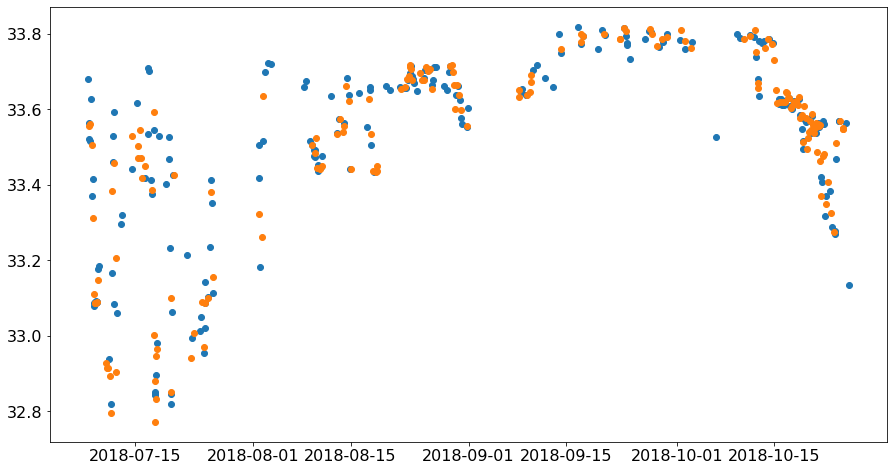

In [21]:
ds1=ds_colJ.isel(trajectory=2)
ds2=ds_colR.isel(trajectory=2)
plt.scatter(ds1.time.data,ds1.SAL_CTD_MEAN)
plt.scatter(ds2.time.data,ds2.SAL_CTD_MEAN)

In [2]:
import xarray as xr
xr.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 20:36:16) [MSC v.1916 64 bit (AMD64)]
python-bits: 64
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 63 Stepping 2, GenuineIntel
byteorder: little
LC_ALL: None
LANG: None
LOCALE: None.None
libhdf5: 1.10.5
libnetcdf: 4.6.2

xarray: 0.16.2
pandas: 1.1.5
numpy: 1.19.4
scipy: 1.5.3
netCDF4: 1.5.1.2
pydap: None
h5netcdf: 0.8.1
h5py: 2.10.0
Nio: None
zarr: 2.4.0
cftime: 1.3.0
nc_time_axis: None
PseudoNetCDF: None
rasterio: 1.0.25
cfgrib: 0.9.8.4
iris: None
bottleneck: 1.3.2
dask: 2.30.0
distributed: 2.30.0
matplotlib: 3.2.1
cartopy: 0.17.0
seaborn: 0.10.0
numbagg: None
pint: None
setuptools: 49.6.0.post20201009
pip: 20.3.3
conda: None
pytest: None
IPython: 7.19.0
sphinx: None
